In [1]:
# basic numeric setup
import numpy as np
print(np.version.version)
import scipy                                                                                                            
import subprocess
import time 
import sys

# plotting
import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
import pandas as pd
rstate = np.random.default_rng(916301)

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

#colors:  
df= ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#5d21d0", "#ff9408", "#dc0ab4", "#b3d4ff", "#00bfa0"] #dutch field
sp= ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]  #spring pastel
op= ["#ffb400", "#d2980d", "#a57c1b", "#786028", "#363445", "#48446e", "#5e569b", "#776bcd", "#9080ff"] #orange-purlpe
pf= ["#0a5f38", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", "#e4bcad", "#df979e", "#d7658b", "#c80064"] #pink foam
sa= ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"] #salmon aqua

C:\Users\Aristomenis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Aristomenis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\Aristomenis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


1.21.0


In [2]:
# Bellow is the data area, also creating your prior space for the fit

fold = "Byfit/"  #for printing results at the end
name = "test 1"  #for creating many cases 

c1 = "#030aa7" #b
c2 = "#aa2704" #r
c3 = "#06470c" #green
    
if name=="test 1": 
    dpa = 140 # in degrees
    dpa_up= 5
    dpa_bot= 5 
    P = 90  # in minutes
    P_up = 3 
    P_bot = 3 
    r = 9   # in M units
    r_up = 0.5  
    r_bot = 0.5 
    truthsdp = [9,90,-0.18] #for synthetic tests with know truths
    cus = c3  #colors for plots 
    cT = pf[-2]
    labels = [r'$r_s$ [M]',r'$P$ [min]',r'$a_\ast$']

    
sig_meas = 1 #sigma confidence of measurament  
sig_res = 2  #sigma confidence of results  
Gauss = True # True for Gauss, False for Linear. If Linear better increase errors, otherwise it cuts strictly at boundaries

#Bellow for orbital speed to period relation
def dpafit(r, a, K):
    Sk = (-1408 +233*a)/r**(2) -35
    Ck = 180+a*(40-r)
    return Sk * K + Ck


In [3]:
if Gauss:
    def prior_transform(u):
        #u= the random par [0,1]. Adjust ranges for all 
        v = u
        #mu_rho = dpa   # THIS FOR UNEVEN DPA ERROR BARS
        #low_rho, high_rho = dpa-dpa_bot, dpa+dpa_up  # lower and upper bounds
        #sig_rho = 1*(high_rho-mu_rho)/(2*sig) + 1*(mu_rho-low_rho)/(2*sig_meas)
        #low_rho_n, high_rho_n = (low_rho - mu_rho) / sig_rho, (high_rho - mu_rho) / sig_rho  # standardize
        #v[0] = scipy.stats.truncnorm.ppf(u[0], low_rho_n, high_rho_n, loc=mu_rho, scale=sig_rho)
        mu_rho = r
        low_rho, high_rho = r-r_bot, r+r_up  # lower and upper bounds
        sig_rho = (high_rho-mu_rho)/(2*sig_meas) + (mu_rho-low_rho)/(2*sig_meas)
        low_rho_n, high_rho_n = (low_rho - mu_rho) / sig_rho, (high_rho - mu_rho) / sig_rho  # standardize
        v[0] = scipy.stats.truncnorm.ppf(u[0], low_rho_n, high_rho_n, loc=mu_rho, scale=sig_rho)
        mu_rho = P
        low_rho, high_rho = P-P_bot, P+P_up  # lower and upper bounds
        sig_rho = (high_rho-mu_rho)/(2*sig_meas) + (mu_rho-low_rho)/(2*sig_meas)
        low_rho_n, high_rho_n = (low_rho - mu_rho) / sig_rho, (high_rho - mu_rho) / sig_rho  # standardize
        v[1] = scipy.stats.truncnorm.ppf(u[1], low_rho_n, high_rho_n, loc=mu_rho, scale=sig_rho)
        v[2] = u[2]*2 - 1
        return v
else:
    def prior_transform(u):
        #u= the random par [0,1]. Adjust ranges for all 
        v = u
        v[0] = r-r_bot + u[0]*(r_up+r_bot)
        v[1] = P - P_bot + u[1]*(P_up+P_bot)
        v[2] = u[2]*2 - 1
        return v

def loglike(v):
    r, P, a = v
    K = 2.2248*(r**(1.5)+a)/P #conversion of Period to Keplerian coefficient for empirical relation
    #K = om*60/360
    start = time.time()
    dpa_emp = dpafit(r,a,K)
    residsq = (dpa_emp  - dpa)**2 / ((dpa_up+dpa_bot)/2)**2 
    loglike = -0.5 * np.sum(residsq)
    #print(loglike)
    end = time.time()
    #print(end - start)
    #log = open("./out_sample.txt", "a", encoding="utf-8") #the name of the output (log) files                                                                    
    #sys.stdout = sys.stderr = log  
    #if not np.isfinite(loglike):
    #    loglike = -1e300    
    return loglike


In [4]:
#Dynesty hyperparameters below

sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, 3,
                                bound= 'multi',sample='auto',rstate=rstate)
sampler.run_nested(nlive_init=1000, maxbatch=2, nlive_batch=1000, 
                                  use_stop=False, wt_kwargs={'pfrac': 1.0})
res = sampler.results

10338it [00:14, 714.49it/s, batch: 2 | bound: 2 | nc: 1 | ncall: 47827 | eff(%): 21.457 | loglstar: -1.508 < -0.000 < -1.151 | logz: -1.647 +/-  0.028 | stop:    nan]           


In [5]:
res.summary()
k= res.__getitem__('logl')
l = len(k)
print(l)
km = max(k)
km2 = k[100]
for xx in range(0,l):
    km_in = k[xx] 
    if (km_in > km2) and (km_in< km) :
        km2 = km_in
        #print(km2)
for xx in range(0,l):
    if k[xx] == -7.103036386783122:
        print ("YES!")
    #else print(No......)
print(km2)
print(km)
z =(res['logz'][-1],res['logzerr'][-1])
key = res.keys()
#print(key)
print(z)
print(len(res['samples']))
plt_2 = False

Summary
niter: 10338
ncall: 47083
eff(%): 21.457
logz: -1.649 +/-  0.026
10338
-3.876432931058503e-11
-2.0762550978009992e-11
(-1.6488804987301904, 0.026013466591433165)
10338


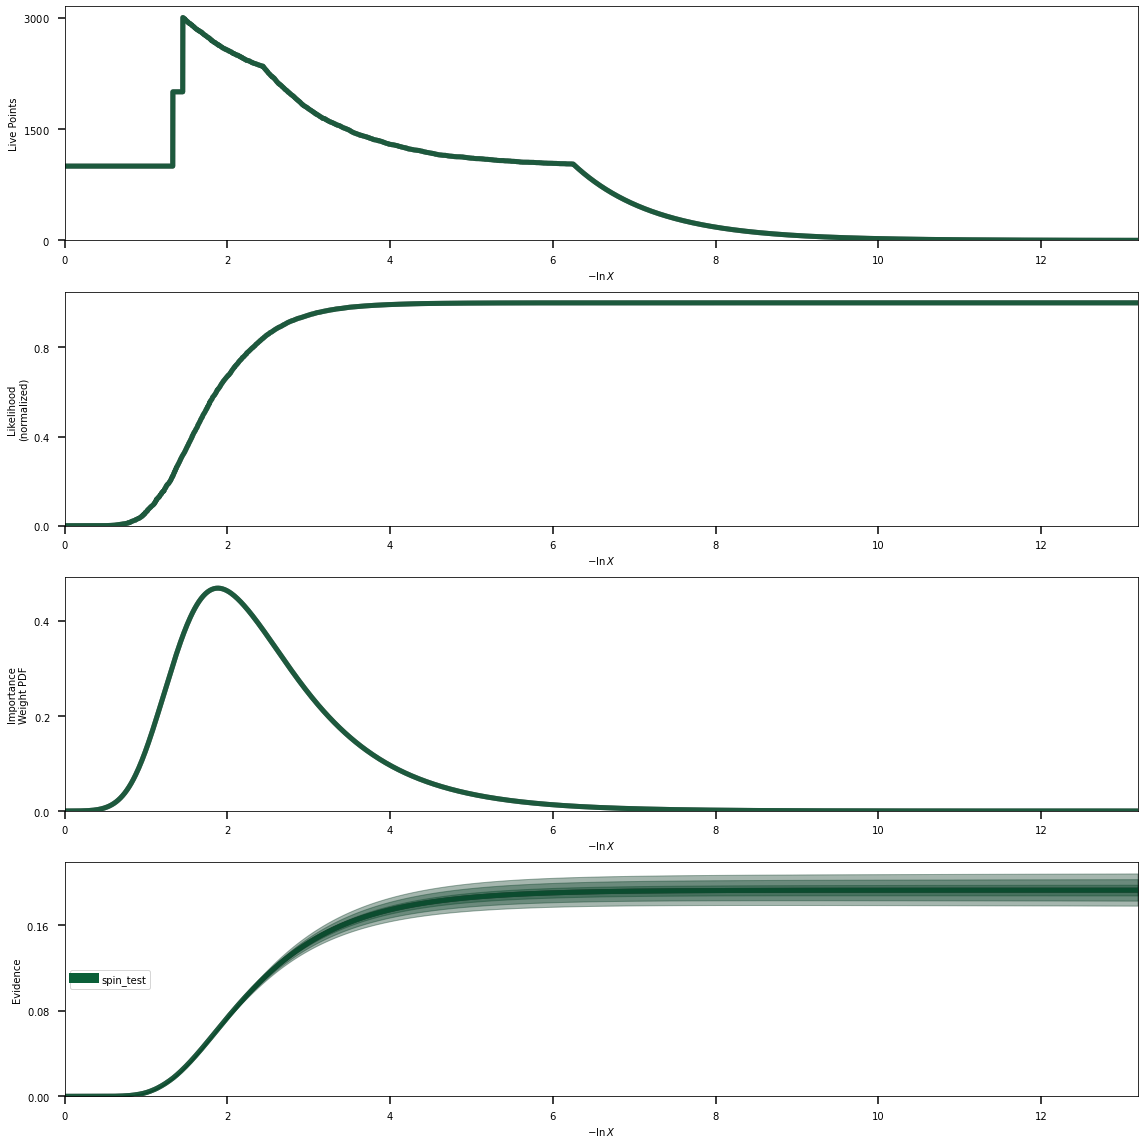

In [6]:
#Diagnostics on convergence, can skip. 

rcParams.update({'font.size': 20})
cool= True
if cool == True: 
    colors = [pf[0],pf[8],df[4],df[5]]
    labs = ["spin_test"]

fig, axes = dyplot.runplot(res, color ="k",)
fig.patch.set_facecolor('w')
dyplot.runplot(res, color = colors[0], fig=(fig, axes))
#dyplot.runplot(res3, color = colors[2], fig=(fig, axes))
#dyplot.runplot(res4, color = colors[3], fig=(fig, axes))
plt.plot(0, -10, color=colors[0],linewidth=10,label=labs[0])
#plt.plot(0, -10, color=colors[2],linewidth=10,label=labs[2])
#plt.plot(0, -10, color=colors[3],linewidth=10,label=labs[3])
plt.legend(loc="center left")
plt.tight_layout()

#plt.savefig(fold+'evidence_'+name+'.png')

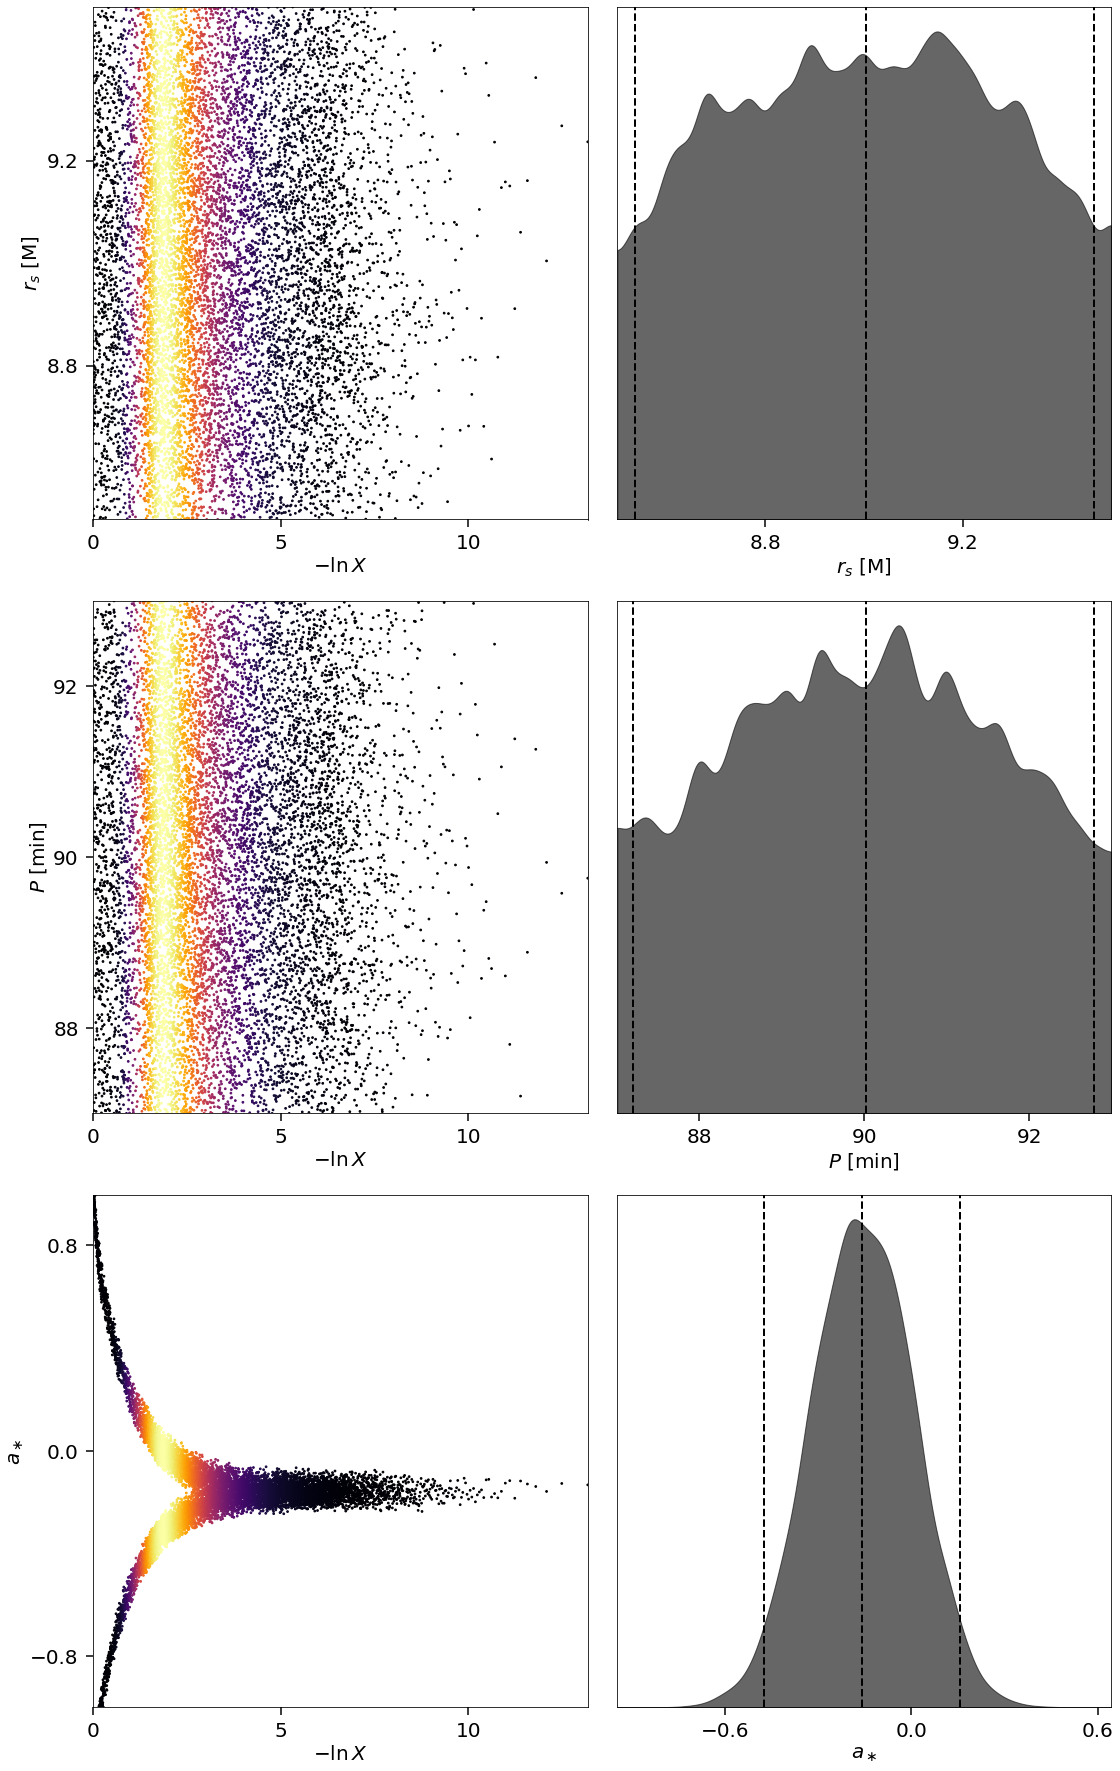

In [7]:
#Visulalization of the run. Can be skipped. 

grayscale = plt.get_cmap('gray')
rcParams.update({'font.size': 20})
fig, axes = dyplot.traceplot(res, labels=labels, truths=None ,max_n_ticks=3, 
                             trace_cmap= "inferno", truth_color='#c0022f',truth_kwargs={'linewidth':3,"alpha":0.7},
                             post_color = "k",
                             fig=plt.subplots(3, 2, figsize=(16, 25)))
fig.tight_layout()
#plt.savefig('plottrace_'+name+'.png')

In [8]:
#CREATING PERCENTILES AND TITLES FOR RES
#sig_res = 1 
if sig_res == 1: 
    quan = (0.15865, 0.5, 0.84835)
if sig_res == 2: 
    quan=(0.025, 0.5, 0.975)

title_quantiles=quan 
title_fmt=".2f"
samples = res['samples']
weights = res.importance_weights()

dims = None
samples = np.atleast_1d(samples)
if len(samples.shape) == 1:
    samples = np.atleast_2d(samples)
else:
    assert len(samples.shape) == 2, "Samples must be 1- or 2-D."
    samples = samples.T
assert samples.shape[0] <= samples.shape[1], "There are more " \
                                                 "dimensions than samples!"
# Slice samples based on provided `dims`.
if dims is not None:
    samples = samples[dims]
ndim, nsamps = samples.shape

# Check weights.
if weights.ndim != 1:
    raise ValueError("Weights must be 1-D.")
if nsamps != weights.shape[0]:
    raise ValueError("The number of weights and samples disagree!")

title2=None
titles = list()
for i, x in enumerate(samples):
    print(i)
    ql, qm, qh = dyfunc.quantile(x, title_quantiles, weights=weights)
    q_minus, q_plus = qm - ql, qh - qm
    fmt = "{{0:{0}}}".format(title_fmt).format
    title2 = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
    title2 = title2.format(fmt(qm), fmt(q_minus), fmt(q_plus))
    title2 = "{0} = {1}".format(labels[i], title2)
    #print(title2)
    titles.append(title2)
print(titles)

0
1
2
['$r_s$ [M] = ${9.00}_{-0.47}^{+0.46}$', '$P$ [min] = ${90.02}_{-2.82}^{+2.77}$', '$a_\\ast$ = ${-0.16}_{-0.32}^{+0.32}$']


3
0
1
2


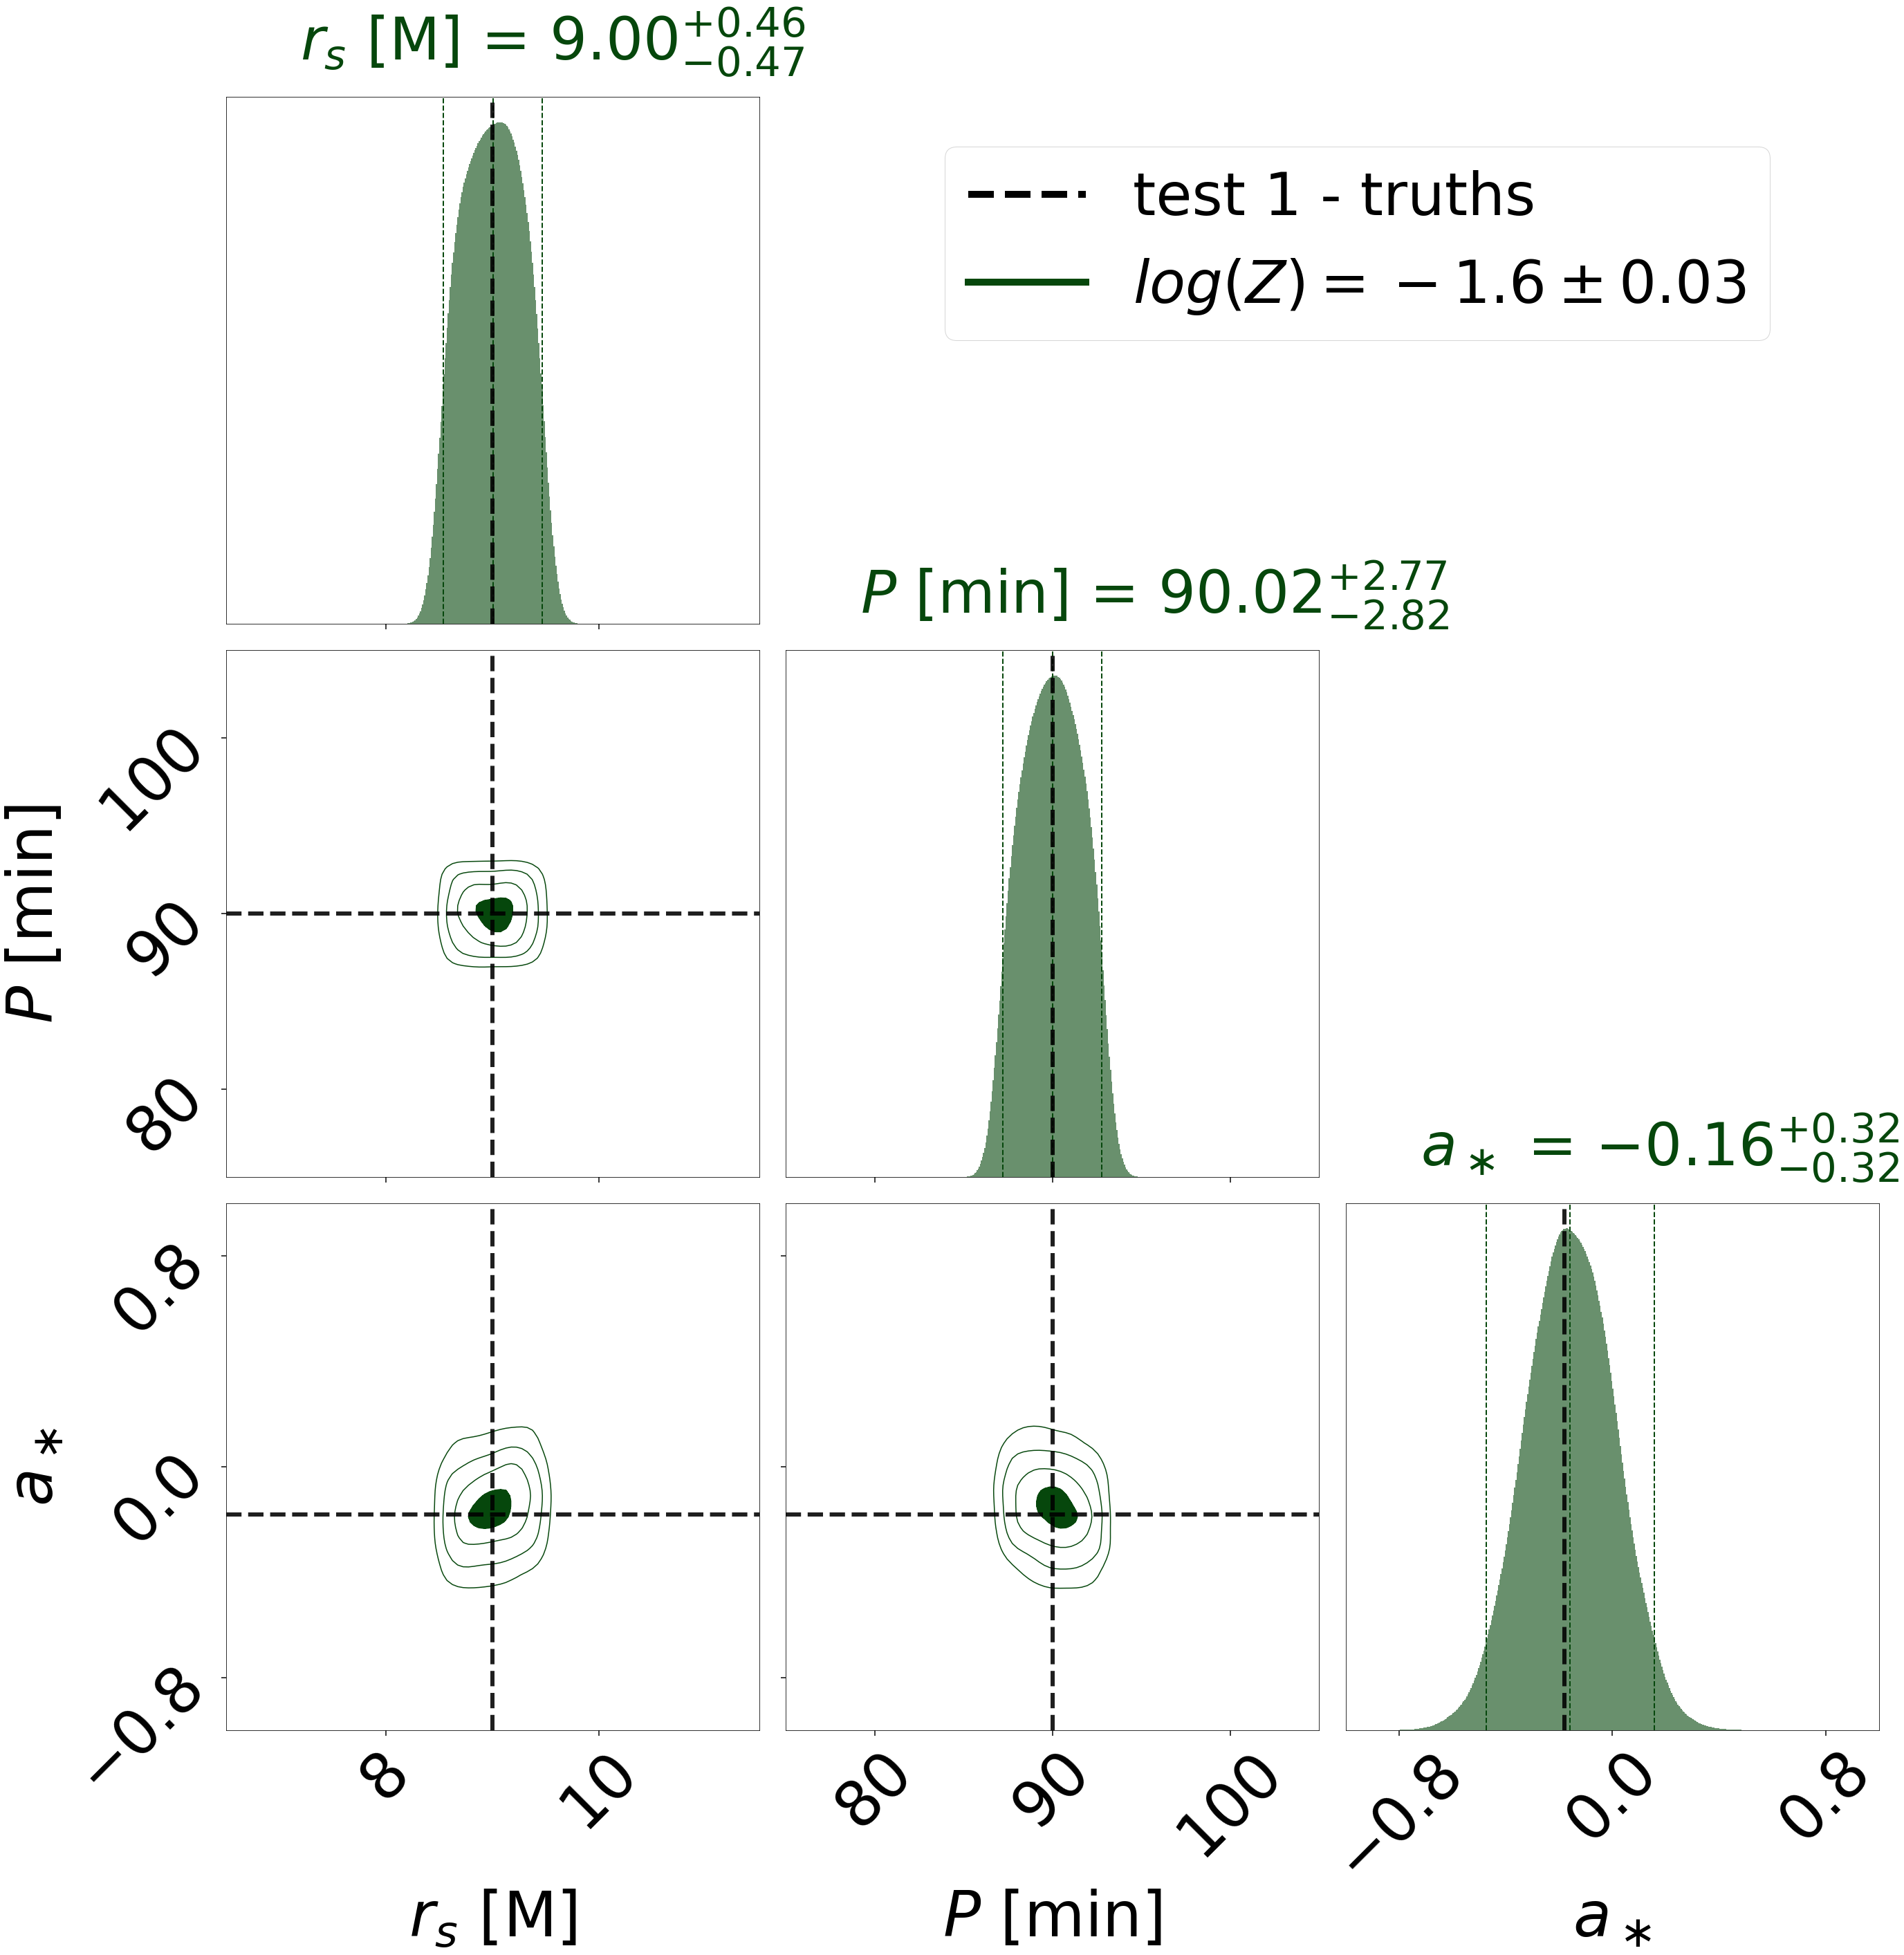

In [9]:
#TRIANGLE PLOTS, WITH TITLES. IF NO TRUTH CLOSE OPTION IN dyplot.cornerplot BELOW
fz = 90
fz2 = 85
rcParams.update({'font.size': fz})

rcParams.update({'font.size': fz})
np = len(titles)
fig, axes = plt.subplots(np,np, figsize=(40, 40))
fig.patch.set_facecolor('w')

#(dpa-2*dpa_bot, dpa+2*dpa_up)
ranges = [(r-5*r_bot, r+5*r_up),(P-5*P_bot, P+5*P_up),(-1,1)]#,(-5,-4)]
truths = [r,P,-4]
ranges = ranges[0:np]    
print(len(ranges))
#plt.subplots(10, 10, figsize=(40, 40))

fg, ax = dyplot.cornerplot(res, color=cus, span = ranges,quantiles=quan, truths=truthsdp ,truth_color="k", 
                           truth_kwargs={'linewidth':6,"alpha":0.88,"linestyle":"--"}, show_titles=None, label_kwargs={'fontsize': fz}, 
                              title_kwargs={"fontsize":fz2,'y': 1.04,'x':1.08},
                              title_fmt=".2f" ,labels=labels,max_n_ticks=3,
                              fig=(fig,axes))

#plt.plot(0, -10, color=cT,linewidth=10,label="observation")
plt.plot(0, -10, color="k",linewidth=10,linestyle="--",label=""+name+" - truths")
plt.plot(0, -10, color=cus,linewidth=10,label=r"$log(Z)=%.1f \pm %.2f$"%(z[0],z[1]))

fig.legend(  bbox_to_anchor=(0.4, 0.4, 0.51, 0.53),fontsize=fz2)

for i, x in enumerate(samples):
    print(i)
    plt.text(0.14+i*0.00,1.07-i*0.00,r""+titles[i],color=cus,transform=axes[i,i].transAxes,fontsize=fz2) #1.38
    #plt.tight_layout(rect=[2, 2, 2, 2],pad=0.5)
    
#plt.subplots_adjust(top=0.94,bottom=0.05,left=0.05,right=0.9)     
plt.subplots_adjust(top=0.94,bottom=0.12,left=0.12,right=0.95)     #for c_b
plt.savefig(fold+'ploT3par_'+name+'.png', dpi=100)
#plt.savefig(fold+'ploT_'+name+'.pdf', dpi=40)